<a href="https://colab.research.google.com/github/Shruti-codes/SHALA2020/blob/master/News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv("drive/My Drive/uci-news-aggregator.csv")

!gdown --id 1fZL9PDPhiEiGp5h_2LNWZ4wAx8tberfT

Downloading...
From: https://drive.google.com/uc?id=1fZL9PDPhiEiGp5h_2LNWZ4wAx8tberfT
To: /content/uci-news-aggregator.csv
103MB [00:01, 65.6MB/s] 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          448000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 522,629
Trainable params: 522,629
Non-trainable params: 0
_________________________________________________________________
{'b', 'm', 't', 'e'}
Epoch 1/10
2641/2641 [==============================] - 325s 123ms/step - loss: 0.2708 - accuracy: 0.9001 - val_loss: 0.4436 - val_accuracy: 0.8397
Epoch 2/10
2641/2641 [==============================] - 327s 124ms/step - loss:

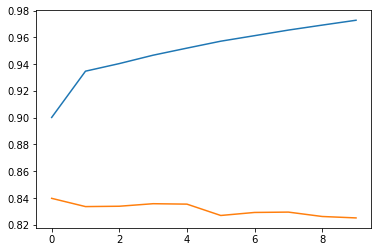

<Figure size 432x288 with 0 Axes>

In [16]:

import csv
import tensorflow as tf
import numpy as np
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

# print(tf.__version__)



articles = []
labels = []

with open('uci-news-aggregator.csv') as file:
	reader = csv.reader(file, delimiter = ",")
	next(reader)
	for row in reader:
		labels.append(row[4])
		article = row[1]
		for word in stopwords:
			token = ' '+word+' '
			article = article.replace(token,' ')
			article = article.replace('  ',' ')
		articles.append(article)

# print(len(labels))
# print(len(articles))

train = int(len(articles)*0.8)
train_data = articles[0:train]
train_labels = labels[0:train]

test_data = articles[train:]
test_labels = labels[train:]

tokenizer = Tokenizer(num_words = 7000, oov_token = 'OOV')
tokenizer.fit_on_texts(train_data)
word_ind = tokenizer.word_index
# print(dict(list(word_ind.items())[0:20]))

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# print(train_sequences[8])

train_padded = pad_sequences(train_sequences, maxlen=50, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=50, padding='post', truncating='post')


label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(7000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

print(set(labels))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs= num_epochs, validation_data = (test_padded, test_label_seq), batch_size = 128, verbose = 1)


acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
loss = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, acc_val)
plt.figure()

(loss, accuracy) = model.evaluate(test_padded, test_label_seq, batch_size=128)
print(accuracy*100)

model.save_weights("uci-news-aggregator.hdf5", overwrite = True)